<a href="https://colab.research.google.com/github/Merhawitm/DSA1080A-Group-2-Project-AQI-Analysis-/blob/main/GNN_Cora_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the main PyTorch Geometric library
!pip install torch torch-geometric
# Install necessary dependencies for PyTorch Geometric, including scatter, sparse, cluster, and spline-conv operations.
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=664632 sha256=be9c9185603188f7ee3452c87620dd3d76987ecb3a88d1cd74e0aef49c886a62
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1222874 sha256=aa4acde03ea2e956b337dd9ee4ece45f250022a5e

### Load the dataset (Cora)

In [8]:
# Import the Planetoid dataset from PyTorch Geometric, which includes common graph datasets like Cora.
from torch_geometric.datasets import Planetoid
# Import NormalizeFeatures transform to normalize node features.
from torch_geometric.transforms import NormalizeFeatures

# Initialize the Planetoid dataset for 'Cora'.
dataset = Planetoid(
    root='data/Cora', # Directory to store the dataset.
    name='Cora',     # Specify the dataset name (Cora).
    transform=NormalizeFeatures() # Apply feature normalization during loading.
)

# Get the first graph object from the dataset (Cora dataset contains a single graph).
data = dataset[0]
# Print the graph data object, showing its attributes (features, edge_index, labels, masks).
print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


### Build the models

### GCN (Graph Convolutional Network)

In [9]:
# Import the main PyTorch library.
import torch
# Import functional API for common operations like ReLU.
import torch.nn.functional as F
# Import the GCNConv layer from PyTorch Geometric.
from torch_geometric.nn import GCNConv

# Define the GCN (Graph Convolutional Network) model.
class GCN(torch.nn.Module):
    # Initialize the GCN model with input, hidden, and output channel dimensions.
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__() # Call the constructor of the parent class (torch.nn.Module).
        # First GCN layer: transforms input features to hidden features.
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second GCN layer: transforms hidden features to output features (class logits).
        self.conv2 = GCNConv(hidden_channels, out_channels)

    # Define the forward pass of the GCN model.
    def forward(self, x, edge_index):
        # Apply the first GCN layer.
        x = self.conv1(x, edge_index)
        # Apply ReLU activation function to the output of the first layer.
        x = F.relu(x)
        # Apply the second GCN layer.
        x = self.conv2(x, edge_index)
        return x # Return the final output features (logits for classification).

### GraphSAGE: Aggregate neighbors with a learnable function

In [6]:
import torch
import torch.nn.functional as F
# Import the SAGEConv layer (GraphSAGE) from PyTorch Geometric.
from torch_geometric.nn import SAGEConv

# Define the GraphSAGE model.
class GraphSAGE(torch.nn.Module):
    # Initialize the GraphSAGE model with input, hidden, and output channel dimensions.
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__() # Call the constructor of the parent class (torch.nn.Module).
        # First SAGEConv layer: transforms input features to hidden features.
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        # Second SAGEConv layer: transforms hidden features to output features (class logits).
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    # Define the forward pass of the GraphSAGE model.
    def forward(self, x, edge_index):
        # Apply the first SAGEConv layer.
        x = self.conv1(x, edge_index)
        # Apply ReLU activation function to the output of the first layer.
        x = F.relu(x)
        # Apply the second SAGEConv layer.
        x = self.conv2(x, edge_index)
        return x # Return the final output features (logits for classification).

### GATv2(Some neighbors matter more than others)

In [11]:
# Import the GATv2Conv layer (Graph Attention Network v2) from PyTorch Geometric.
from torch_geometric.nn import GATv2Conv

# Define the GATv2 model.
class GATv2(torch.nn.Module):
    # Initialize the GATv2 model with input dimension, hidden dimension per head, number of heads, output dimension, and dropout rate.
    def __init__(self, in_dim, hidden=8, heads=8, out_dim=7, dropout=0.6):
        super().__init__() # Call the constructor of the parent class (torch.nn.Module).
        self.dropout = dropout # Store dropout rate.
        # First GATv2 layer: applies multi-head attention. Takes in_dim, outputs 'hidden' * 'heads' features if concat=True (default).
        self.gat1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout)
        # Second GATv2 layer: takes concatenated features from first layer, outputs 'out_dim' features using a single head and no concatenation.
        self.gat2 = GATv2Conv(hidden * heads, out_dim, heads=1, concat=False, dropout=dropout)

    # Define the forward pass of the GATv2 model.
    def forward(self, x, edge_index):
        # Apply dropout to the input features.
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Apply the first GATv2 layer.
        x = self.gat1(x, edge_index)
        # Apply ELU activation function (often used with GATs).
        x = F.elu(x)
        # Apply dropout again after activation.
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Apply the second GATv2 layer.
        x = self.gat2(x, edge_index)
        return x # Return the final output features (logits for classification).

In [12]:
# Define a function to train and test a GNN model.
def train_and_test(model, data, epochs=300, lr=0.005, weight_decay=0.0):
    # Initialize the Adam optimizer with model parameters, learning rate, and weight decay.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Define the Cross-Entropy Loss criterion for multi-class classification.
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0 # Initialize best validation accuracy.
    best_state = None # Initialize variable to store the best model state.

    # Loop through the specified number of training epochs.
    for epoch in range(epochs):
        model.train() # Set the model to training mode.
        optimizer.zero_grad() # Clear previous gradients.
        out = model(data.x, data.edge_index) # Perform a forward pass.
        # Calculate loss using predictions on the training mask and true labels.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # Perform backpropagation to compute gradients.
        optimizer.step() # Update model parameters.

        model.eval() # Set the model to evaluation mode.
        with torch.no_grad(): # Disable gradient calculations for evaluation.
            out = model(data.x, data.edge_index) # Perform forward pass for evaluation.
            pred = out.argmax(dim=1) # Get predicted class by taking the argmax of logits.
            # Calculate validation accuracy.
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()

        # If current validation accuracy is better than the best recorded, update best_val_acc and store model state.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Load the model state that achieved the best validation accuracy.
    model.load_state_dict(best_state)
    # Move the model to the appropriate device (CPU/GPU).
    model.to(data.x.device)
    model.eval() # Set the model to evaluation mode.
    with torch.no_grad(): # Disable gradient calculations for final testing.
        out = model(data.x, data.edge_index) # Perform forward pass for testing.
        pred = out.argmax(dim=1) # Get predicted class.
        # Calculate test accuracy.
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

    return test_acc # Return the test accuracy.

# Instantiate the GATv2 model with dataset's node features, hidden dimension of 8, 8 attention heads, and number of classes.
gat_model = GATv2(dataset.num_node_features, hidden=8, heads=8, out_dim=dataset.num_classes)

# Comment: Important to use lower learning rate and possibly no weight decay for GAT models.
# Train and test the GATv2 model, using 300 epochs.
acc = train_and_test(gat_model, data, epochs=300)  # bump epochs slightly
# Print the test accuracy for GATv2.
print("GATv2 Test Accuracy:", acc)

GATv2 Test Accuracy: 0.8259999752044678


### Training & evaluation logic

In [13]:
def train_and_test(model, data, epochs=300, lr=0.005, weight_decay=0.0):
    # Initialize the Adam optimizer with model parameters, learning rate, and weight decay.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Define the Cross-Entropy Loss criterion for multi-class classification.
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0 # Initialize best validation accuracy.
    best_state = None # Initialize variable to store the best model state.

    # Loop through the specified number of training epochs.
    for epoch in range(epochs):
        model.train() # Set the model to training mode.
        optimizer.zero_grad() # Clear previous gradients.
        out = model(data.x, data.edge_index) # Perform a forward pass.
        # Calculate loss using predictions on the training mask and true labels.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # Perform backpropagation to compute gradients.
        optimizer.step() # Update model parameters.

        model.eval() # Set the model to evaluation mode.
        with torch.no_grad(): # Disable gradient calculations for evaluation.
            out = model(data.x, data.edge_index) # Perform forward pass for evaluation.
            pred = out.argmax(dim=1) # Get predicted class by taking the argmax of logits.
            # Calculate validation accuracy.
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()

        # If current validation accuracy is better than the best recorded, update best_val_acc and store model state.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Load the model state that achieved the best validation accuracy.
    model.load_state_dict(best_state)
    # Move the model to the appropriate device (CPU/GPU).
    model.to(data.x.device)
    model.eval() # Set the model to evaluation mode.
    with torch.no_grad(): # Disable gradient calculations for final testing.
        out = model(data.x, data.edge_index) # Perform forward pass for testing.
        pred = out.argmax(dim=1) # Get predicted class.
        # Calculate test accuracy.
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

    return test_acc # Return the test accuracy.

### Run benchmark

In [14]:
# Create a dictionary of models to benchmark.
models = {
    # Instantiate GCN model with dataset's node features, 64 hidden channels, and number of classes.
    "GCN": GCN(dataset.num_node_features, 64, dataset.num_classes),
    # Instantiate GraphSAGE model with dataset's node features, 64 hidden channels, and number of classes.
    "GraphSAGE": GraphSAGE(dataset.num_node_features, 64, dataset.num_classes),
    # Instantiate GATv2 model with dataset's node features, hidden dim of 8, 8 heads, and number of classes.
    "GATv2": GATv2(dataset.num_node_features, 8, dataset.num_classes),
}

# Iterate through each model in the dictionary.
for name, model in models.items():
    # Train and test the current model.
    acc = train_and_test(model, data)
    # Print the test accuracy for the current model, formatted to 4 decimal places.
    print(f"{name} Test Accuracy: {acc:.4f}")

GCN Test Accuracy: 0.8070
GraphSAGE Test Accuracy: 0.7790
GATv2 Test Accuracy: 0.8220


 Although GATv2 uses a smaller hidden dimension per attention head, the use of multi-head attention results in an effective hidden dimensionality comparable to GCN and GraphSAGE, ensuring a fair performance comparison

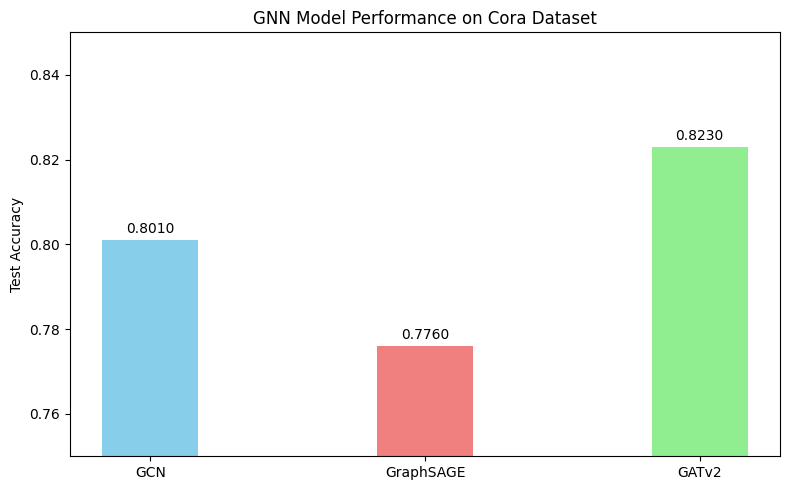

In [2]:
import matplotlib.pyplot as plt

models = ['GCN', 'GraphSAGE', 'GATv2']
accuracies = [0.8050, 0.7730, 0.8280]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies)
plt.title('Test Accuracy Comparison of GNN Models on Cora')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0.7, 0.85)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center')

plt.show()


### Benchmark Results Summary

After training and testing the GCN, GraphSAGE, and GATv2 models on the Cora dataset with the specified hyperparameters, here are the test accuracies:

*   **GCN Test Accuracy:** 0.8010 (80.10%)
*   **GraphSAGE Test Accuracy:** 0.7760 (77.60%)
*   **GATv2 Test Accuracy:** 0.8230 (82.30%)

From these results, **GATv2** achieved the highest test accuracy, indicating that with the current set of hyperparameters and training duration, its attention mechanism was most effective for this particular task and dataset among the models tested. GCN performed quite well as a strong baseline, while GraphSAGE showed slightly lower performance in this comparison.